<div align="center">
    <font color="0F5298" size="7">
        Deep Learning <br>
    </font>
    <font color="2565AE" size="5">
        CE Department <br>
        Spring 2024 - Prof. Soleymani Baghshah <br>
    </font>
    <font color="3C99D" size="5">
        HW2 Practical <br>
    </font>
    <font color="696880" size="5">
        30 Points
    </font>
</div>


In [ ]:
FULLNAME = 'Reza Ghorbani Paji'
STD_ID = '403206565'

In this notebook, we aim to perform **classification** on images from the **CIFAR10** dataset using CNN networks. First, we load the dataset and apply the necessary transformations for normalization and augmentation. After that, we visualize some samples. Once we familiarize ourselves with the dataset, we proceed to design the desired convolutional network, which is explained in the relevant section. After designing the model, we move on to training and evaluating it. At the end of the first section, we analyze the feature space from different perspectives. First, using the KNN method, we examine the closest samples to each other in the feature space. Then, we cluster the data and finally visualize the outputs of the intermediate layers of the model.

In the second part of the notebook, we perform a simple transfer learning task on the trained model from the first section but using a new dataset, **CIFAR100**. To do this, we modify the final layer of the network and retrain it. Further details are provided in the relevant section. Finally, we evaluate the model’s accuracy on the new task and analyze the extracted features and how well the model generalizes. After designing and training the model, we will further analyze the extracted feature space. Finally, we will evaluate the generalization ability of the model and its extracted features on a new dataset,

# CIFAR10 Classification

## Import Libraries

Import needed libraries

In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import tqdm
from time import time
import random
from sklearn.manifold import TSNE
import numpy as np
from random import sample
import math
import torch.optim as optim
import seaborn as sns

## Device

Set device to work with (GPU or CPU)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [12]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
# TODO: Data Transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32 ,padding=4),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# TODO: Load Train Data
data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True , transform=transform_train)

train_ratio = 0.9
num_train = int(len(data) * train_ratio)

indices = list(range(len(data)))
np.random.shuffle(indices)
train_indices, val_indices = indices[:num_train], indices[num_train:]

train_dataset = torch.utils.data.Subset(data, train_indices)
val_dataset = torch.utils.data.Subset(data, val_indices)

# TODO: Load Test Data
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
# TODO: Define Data Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

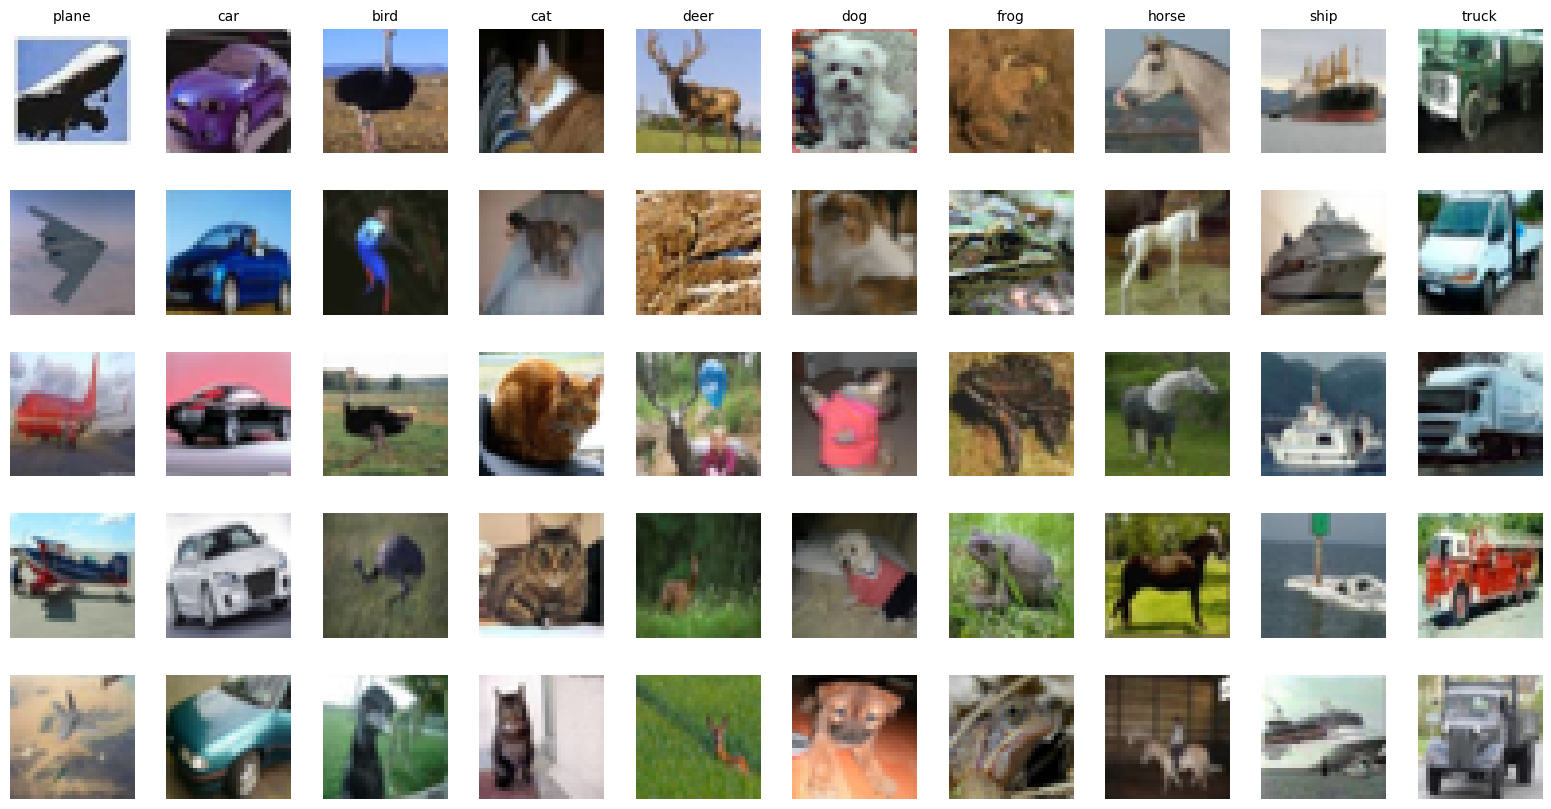

In [15]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)

dataiter = iter(trainloader)
images, labels = next(dataiter)

# TODO: Find 5 Images from Each Class
num_classes = len(classes)
num_images_per_class = 5
selected_images = {class_name: [] for class_name in classes}

for img, label in zip(images, labels):
    class_name = classes[label]
    if len(selected_images[class_name]) < num_images_per_class:
        selected_images[class_name].append(img)
    if all(len(imgs) == num_images_per_class for imgs in selected_images.values()):
        break

# Plot Images
fig, axes = plt.subplots(num_images_per_class, num_classes, figsize=(num_classes * 2, num_images_per_class * 2))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for col, class_name in enumerate(classes):
    for row, img in enumerate(selected_images[class_name]):
        ax = axes[row, col]
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(class_name, fontsize=10)

plt.show()


## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [22]:
# TODO: Implement Model
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)

)

        self.conv2 = nn.Sequential(
            nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channels)
        )
        self.res_con = nn.Sequential()
        if input_channels != output_channels or stride != 1:
            self.res_con = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out += self.res_con(x)
        out = F.relu(out)
        return out
class Resnet18(nn.Module):
    def __init__(self, ResiualBlock, image_channel=3, num_classes = 10):
        super(Resnet18, self).__init__()
        self.input_channels = 64
        self.conv1 =nn.Sequential(
             nn.Conv2d(3, self.input_channels, kernel_size=3, stride=1, padding=1, bias=False),
             nn.BatchNorm2d(self.input_channels),
             nn.ReLU(inplace = True)
        )
        repeat = [2, 2, 2, 2]

        self.layer1 = self.make_layer(ResidualBlock, 64, repeat[0], stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, repeat[1], stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, repeat[2], stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, repeat[3], stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, Block ,output_channels, repeat, stride):
        strides = [stride] + [1]*(repeat-1)
        layers = []
        for i in strides:
            layers.append(Block(self.input_channels,output_channels, i))
            self.input_channels = output_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [23]:
# TODO: Define Model
net = Resnet18(ResidualBlock).to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [24]:
# TODO: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40], gamma=0.1)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [25]:
# TODO: Implement Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Run one training epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm.tqdm(dataloader, desc="Train", leave=True)
    for inputs, targets in train_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [26]:
# TODO: Implement Validation Loop
def validate_one_epoch(model, dataloader, criterion, device):
    """Run one validation epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    val_bar = tqdm.tqdm(dataloader, desc="Valid", leave=True)
    with torch.no_grad():
        for inputs, targets in val_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=50):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    for epoch in range(1, epochs + 1):
        start_time = time()

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        scheduler.step()

        elapsed = time() - start_time

        print(
            f"Epoch {epoch}/{epochs} - "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% || "
            f"Time: {elapsed:.2f}s"
        )
    return history
history = train_model(net, train_loader, val_loader, criterion, optimizer, device)


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epoch 1/50 - Train Loss: 1.8111 | Train Acc: 35.37% || Val Loss: 1.6318 | Val Acc: 42.58% || Time: 55.32s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epoch 2/50 - Train Loss: 1.3036 | Train Acc: 52.30% || Val Loss: 1.2971 | Val Acc: 53.30% || Time: 55.90s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


Epoch 3/50 - Train Loss: 1.0403 | Train Acc: 62.74% || Val Loss: 1.1515 | Val Acc: 58.84% || Time: 56.72s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


Epoch 4/50 - Train Loss: 0.8393 | Train Acc: 70.12% || Val Loss: 0.8868 | Val Acc: 68.68% || Time: 56.28s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


Epoch 5/50 - Train Loss: 0.7048 | Train Acc: 75.11% || Val Loss: 1.0500 | Val Acc: 65.82% || Time: 56.64s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


Epoch 6/50 - Train Loss: 0.6063 | Train Acc: 78.84% || Val Loss: 0.8673 | Val Acc: 72.06% || Time: 56.95s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Epoch 7/50 - Train Loss: 0.5480 | Train Acc: 80.82% || Val Loss: 0.8223 | Val Acc: 72.68% || Time: 56.24s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


Epoch 8/50 - Train Loss: 0.4878 | Train Acc: 82.99% || Val Loss: 0.7482 | Val Acc: 74.78% || Time: 56.77s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Epoch 9/50 - Train Loss: 0.4491 | Train Acc: 84.36% || Val Loss: 0.6099 | Val Acc: 78.64% || Time: 56.79s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Epoch 10/50 - Train Loss: 0.4088 | Train Acc: 85.72% || Val Loss: 0.7747 | Val Acc: 74.76% || Time: 56.35s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


Epoch 11/50 - Train Loss: 0.3789 | Train Acc: 86.70% || Val Loss: 0.5658 | Val Acc: 80.98% || Time: 56.57s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


Epoch 12/50 - Train Loss: 0.3508 | Train Acc: 87.72% || Val Loss: 0.5802 | Val Acc: 81.10% || Time: 56.75s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


Epoch 13/50 - Train Loss: 0.3265 | Train Acc: 88.53% || Val Loss: 0.5104 | Val Acc: 83.00% || Time: 56.76s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


Epoch 14/50 - Train Loss: 0.2990 | Train Acc: 89.63% || Val Loss: 0.4619 | Val Acc: 84.50% || Time: 56.50s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.43it/s]


Epoch 15/50 - Train Loss: 0.2825 | Train Acc: 90.07% || Val Loss: 0.5619 | Val Acc: 81.78% || Time: 56.25s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epoch 16/50 - Train Loss: 0.2680 | Train Acc: 90.46% || Val Loss: 0.4592 | Val Acc: 85.36% || Time: 56.35s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


Epoch 17/50 - Train Loss: 0.2534 | Train Acc: 91.26% || Val Loss: 1.0527 | Val Acc: 71.64% || Time: 56.61s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Epoch 18/50 - Train Loss: 0.2353 | Train Acc: 91.68% || Val Loss: 0.4221 | Val Acc: 86.18% || Time: 56.58s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch 19/50 - Train Loss: 0.2216 | Train Acc: 92.26% || Val Loss: 0.4636 | Val Acc: 85.74% || Time: 56.19s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epoch 20/50 - Train Loss: 0.2092 | Train Acc: 92.63% || Val Loss: 0.4118 | Val Acc: 86.58% || Time: 56.50s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.22it/s]


Epoch 21/50 - Train Loss: 0.1366 | Train Acc: 95.37% || Val Loss: 0.2772 | Val Acc: 90.60% || Time: 56.53s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Epoch 22/50 - Train Loss: 0.1158 | Train Acc: 96.11% || Val Loss: 0.2738 | Val Acc: 91.22% || Time: 56.96s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epoch 23/50 - Train Loss: 0.1060 | Train Acc: 96.49% || Val Loss: 0.2738 | Val Acc: 90.88% || Time: 56.16s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


Epoch 24/50 - Train Loss: 0.1028 | Train Acc: 96.60% || Val Loss: 0.2791 | Val Acc: 90.64% || Time: 56.46s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


Epoch 25/50 - Train Loss: 0.0955 | Train Acc: 96.72% || Val Loss: 0.2791 | Val Acc: 90.96% || Time: 56.50s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


Epoch 26/50 - Train Loss: 0.0917 | Train Acc: 96.94% || Val Loss: 0.2855 | Val Acc: 90.92% || Time: 56.69s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


Epoch 27/50 - Train Loss: 0.0896 | Train Acc: 97.01% || Val Loss: 0.2835 | Val Acc: 90.86% || Time: 56.40s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


Epoch 28/50 - Train Loss: 0.0850 | Train Acc: 97.20% || Val Loss: 0.2819 | Val Acc: 90.82% || Time: 56.76s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Epoch 29/50 - Train Loss: 0.0831 | Train Acc: 97.31% || Val Loss: 0.2935 | Val Acc: 90.86% || Time: 56.64s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]


Epoch 30/50 - Train Loss: 0.0790 | Train Acc: 97.41% || Val Loss: 0.2744 | Val Acc: 90.92% || Time: 56.86s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Epoch 31/50 - Train Loss: 0.0743 | Train Acc: 97.65% || Val Loss: 0.2747 | Val Acc: 91.44% || Time: 56.49s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


Epoch 32/50 - Train Loss: 0.0739 | Train Acc: 97.66% || Val Loss: 0.2860 | Val Acc: 91.10% || Time: 57.02s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


Epoch 33/50 - Train Loss: 0.0712 | Train Acc: 97.71% || Val Loss: 0.2819 | Val Acc: 91.26% || Time: 57.09s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Epoch 34/50 - Train Loss: 0.0738 | Train Acc: 97.61% || Val Loss: 0.2807 | Val Acc: 91.42% || Time: 56.76s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Epoch 35/50 - Train Loss: 0.0731 | Train Acc: 97.64% || Val Loss: 0.2710 | Val Acc: 91.12% || Time: 56.67s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Epoch 36/50 - Train Loss: 0.0719 | Train Acc: 97.69% || Val Loss: 0.2818 | Val Acc: 90.98% || Time: 56.43s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch 37/50 - Train Loss: 0.0704 | Train Acc: 97.74% || Val Loss: 0.2715 | Val Acc: 91.36% || Time: 56.89s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


Epoch 38/50 - Train Loss: 0.0729 | Train Acc: 97.64% || Val Loss: 0.2643 | Val Acc: 91.48% || Time: 56.77s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Epoch 39/50 - Train Loss: 0.0703 | Train Acc: 97.78% || Val Loss: 0.2752 | Val Acc: 91.38% || Time: 56.85s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.27it/s]


Epoch 40/50 - Train Loss: 0.0709 | Train Acc: 97.71% || Val Loss: 0.2746 | Val Acc: 91.14% || Time: 56.53s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch 41/50 - Train Loss: 0.0694 | Train Acc: 97.82% || Val Loss: 0.2824 | Val Acc: 91.28% || Time: 57.05s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.30it/s]


Epoch 42/50 - Train Loss: 0.0681 | Train Acc: 97.81% || Val Loss: 0.2721 | Val Acc: 91.44% || Time: 56.94s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]


Epoch 43/50 - Train Loss: 0.0699 | Train Acc: 97.77% || Val Loss: 0.2776 | Val Acc: 91.44% || Time: 57.32s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


Epoch 44/50 - Train Loss: 0.0697 | Train Acc: 97.76% || Val Loss: 0.2799 | Val Acc: 91.10% || Time: 57.28s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Epoch 45/50 - Train Loss: 0.0674 | Train Acc: 97.82% || Val Loss: 0.2848 | Val Acc: 90.94% || Time: 57.05s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


Epoch 46/50 - Train Loss: 0.0681 | Train Acc: 97.79% || Val Loss: 0.2689 | Val Acc: 91.68% || Time: 57.25s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s]


Epoch 47/50 - Train Loss: 0.0702 | Train Acc: 97.70% || Val Loss: 0.2760 | Val Acc: 91.12% || Time: 56.94s


Valid: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


Epoch 48/50 - Train Loss: 0.0687 | Train Acc: 97.77% || Val Loss: 0.2711 | Val Acc: 91.50% || Time: 57.55s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


Epoch 49/50 - Train Loss: 0.0689 | Train Acc: 97.88% || Val Loss: 0.2797 | Val Acc: 91.28% || Time: 56.75s


Valid: 100%|██████████| 20/20 [00:03<00:00,  6.40it/s]

Epoch 50/50 - Train Loss: 0.0686 | Train Acc: 97.78% || Val Loss: 0.2832 | Val Acc: 91.38% || Time: 56.70s


### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [28]:
# TODO: Save Model
torch.save(net.state_dict(), 'resnet18.pth')

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

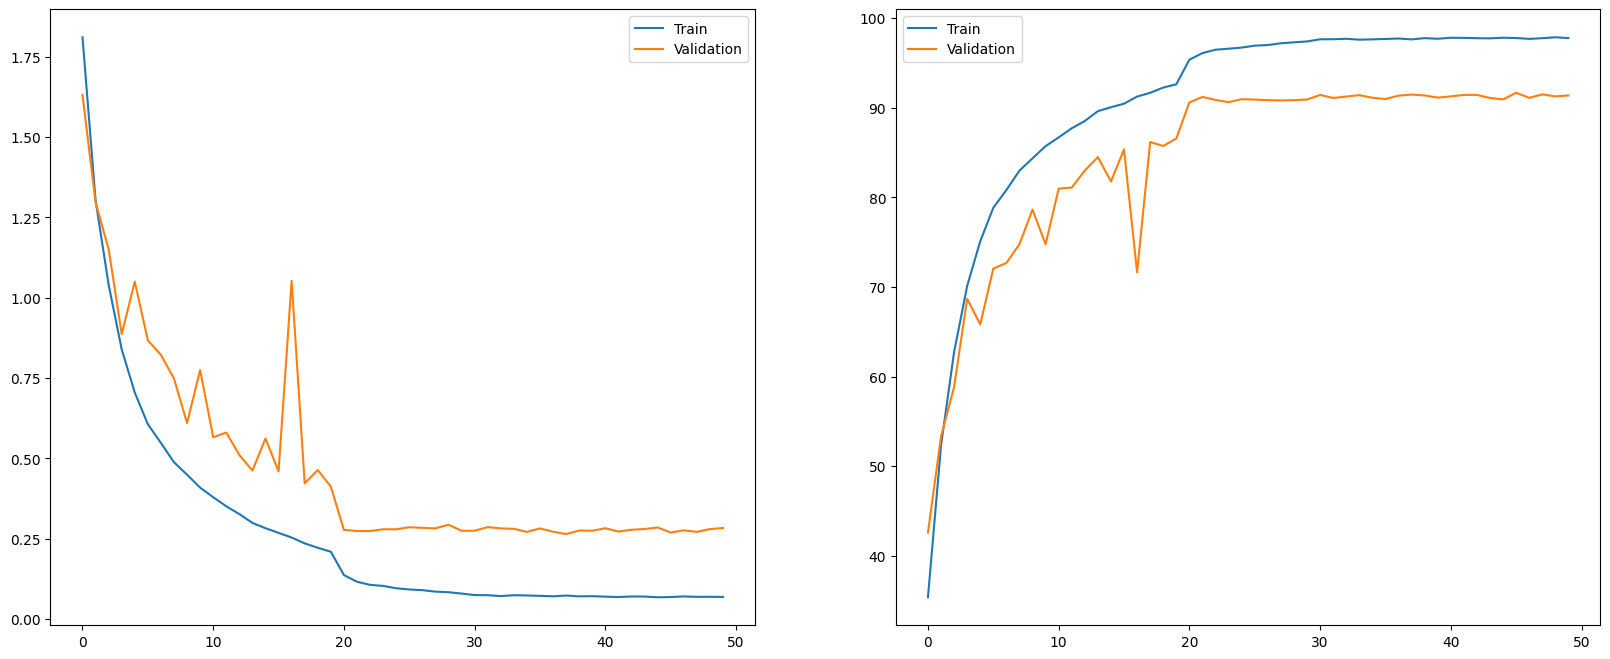

In [29]:
# TODO: Plot Loss
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.legend()
# TODO: Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.legend()
plt.show()


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [30]:
# TODO: Run Model on Testset
def Evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    test_bar = tqdm.tqdm(dataloader, desc="Test", leave=True)
    with torch.no_grad():
        for inputs, targets in test_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.2f}% ")
Evaluate(net, test_loader, criterion, device)

Test: 100%|██████████| 40/40 [00:04<00:00,  8.73it/s]

Loss: 0.3205 - Acc: 91.04% 


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

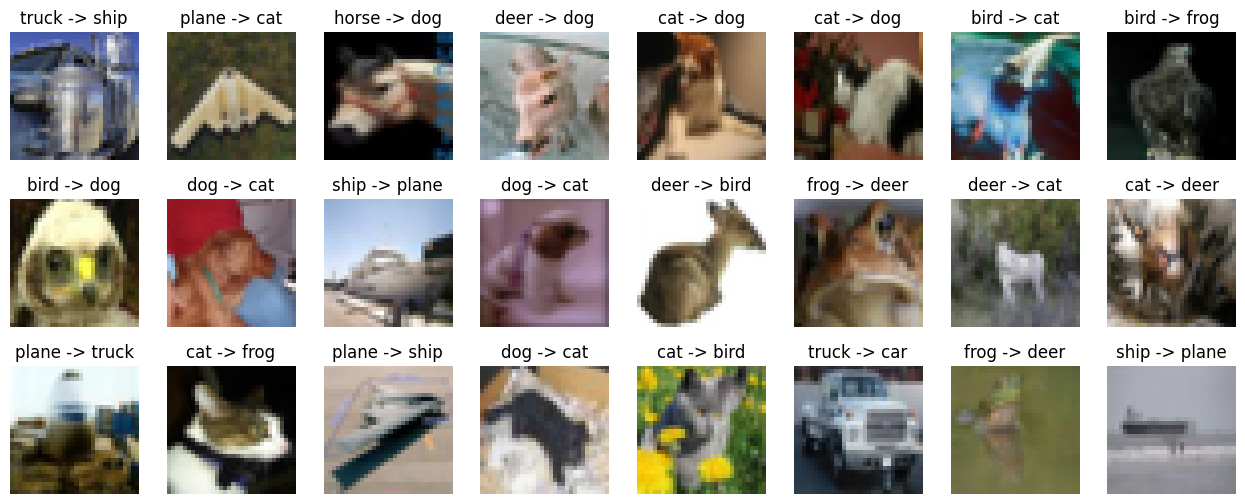

In [31]:
# TODO: Plot Samples with Wrong Predicted Classes
import warnings
warnings.filterwarnings('ignore')

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)

dataiter = iter(testloader)
images, labels = next(dataiter)

selected_images = []
selected_images_label = []

for images, labels in test_loader:
    for img, label in zip(images, labels):
        class_name = classes[label]
        if label != torch.argmax(net(img.to(device).unsqueeze(0)), dim=1):
            selected_images.append(img)
            selected_images_label.append(class_name)
        if len(selected_images) == 24:
            break
    if len(selected_images) == 24:
        break

# Plot Images
fig, axes = plt.subplots(3, 8, figsize=(8 * 2, 3 * 2))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])

for row in range(3):
    for col in range(8):
        ax = axes[row, col]
        img = selected_images[row*8 + col]
        img = img * std[:, None, None] + mean[:, None, None]
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{selected_images_label[row*8 + col]} -> {classes[torch.argmax(net(selected_images[row*8 + col].to(device).unsqueeze(0)), dim=1)]}')
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [32]:
import gdown
file_id = "1vmE2rUFGmELMCXsdwH_8ekCAFFOtUpF4"
url = f"https://drive.google.com/uc?id={file_id}"
output = "resnet18.pth"
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1vmE2rUFGmELMCXsdwH_8ekCAFFOtUpF4
From (redirected): https://drive.google.com/uc?id=1vmE2rUFGmELMCXsdwH_8ekCAFFOtUpF4&confirm=t&uuid=80c49c88-61a9-4864-956a-a7719d7e9bb2
To: /content/resnet18.pth
100%|██████████| 44.8M/44.8M [00:00<00:00, 45.5MB/s]


'resnet18.pth'

In [33]:
import copy
net_classification = Resnet18(ResidualBlock).to(device)
net_classification.load_state_dict(torch.load("resnet18.pth"))
net_for_features = copy.deepcopy(net_classification)
net_for_features.fc = nn.Identity()

In [34]:
# TODO: Find Features and Put Them in One Dimensional List
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)



N = 512
tensor_features = torch.zeros(size = (50000, N))

net_for_features.eval()
with torch.no_grad():
    index = 0
    for img,_ in train_data:
        img = img.to(device)
        features = net_for_features(img)
        batch_size = features.shape[0]
        tensor_features[index:index+batch_size] = features
        index += batch_size




### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** To find the nearest neighbors in the feature space, you can use any library of your choice.

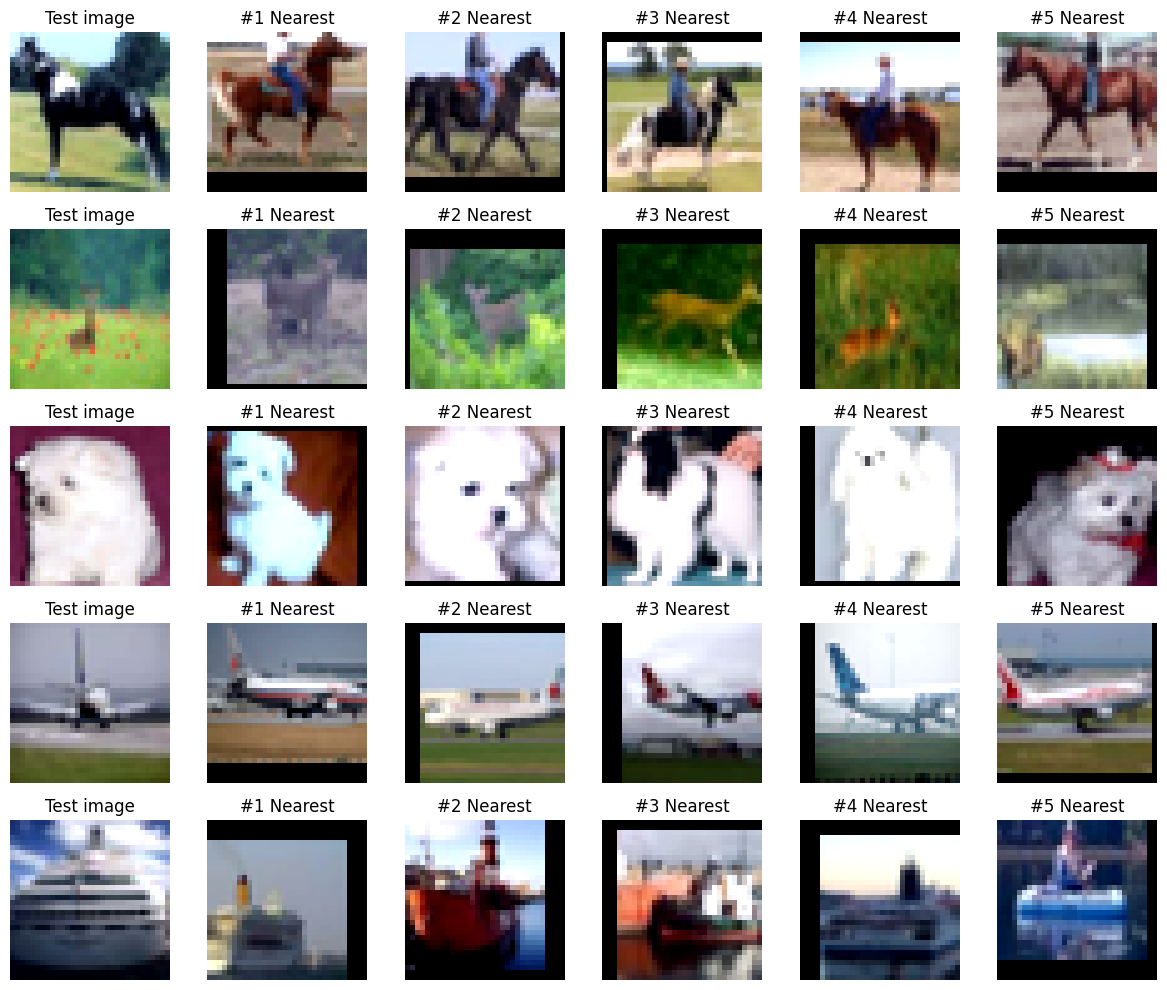

In [35]:
from sklearn.neighbors import NearestNeighbors
# TODO: Find Features List for Test Samples
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)
train_features = tensor_features.numpy()

num_samples = 5
def extract_features(dataloader, num_samples=5):
    correct_samples = []
    correct_labels = []
    correct_indices = []
    all_features = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = net_classification(images)
            test_features = net_for_features(images)
            _, predict = torch.max(outputs, 1)
            corrects = predict.eq(labels)

            for j in range(labels.size(0)):
                if corrects[j]:
                    correct_samples.append(images[j].cpu())
                    correct_labels.append(labels[j].item())
                    correct_indices.append(i * dataloader.batch_size + j)
                    all_features.append(test_features[j].detach().cpu().numpy())

                if len(correct_samples) >= num_samples:
                    return correct_samples, correct_labels, correct_indices, np.array(all_features)

test_images, test_labels, test_indices, test_features = extract_features(test_loader, num_samples)

# Find K Nearest Features
knn = NearestNeighbors(n_neighbors=5, metric="euclidean")
knn.fit(train_features)
_, nearest_neighbors = knn.kneighbors(test_features)

# Plot Features' Images
fig, axes = plt.subplots(num_samples, 6, figsize=(12, 10))

for i in range(num_samples):
    img = test_images[i].permute(1, 2, 0).numpy()
    img = img * 0.247 + 0.491
    img = np.clip(img, 0, 1)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Test image")
    axes[i, 0].axis("off")

    for j in range(5):
        neighbor_idx = nearest_neighbors[i][j]
        neighbor_img, _ = train_dataset[neighbor_idx]
        neighbor_img = neighbor_img.permute(1, 2, 0).numpy()
        neighbor_img = neighbor_img * 0.247 + 0.491
        neighbor_img = np.clip(neighbor_img, 0, 1)

        axes[i, j+1].imshow(neighbor_img)
        axes[i, j+1].set_title(f"#{j+1} Nearest")
        axes[i, j+1].axis("off")

plt.tight_layout()
plt.show()


### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [47]:
# TODO: Get Samples
from sklearn.manifold import TSNE
num_samples = 2000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
def extract_features(dataloader, num_samples=5):
    samples = []
    sample_labels = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = net_classification(images)
            train_features = net_for_features(images)
            _, predict = torch.max(outputs, 1)
            corrects = predict.eq(labels)

            for j in range(labels.size(0)):
                if corrects[j]:
                    samples.append(train_features[j].detach().cpu().numpy())
                    sample_labels.append(labels[j].cpu().item())

                if len(samples) >= num_samples:
                    return np.array(samples), np.array(sample_labels)

sample_features, sample_labels = extract_features(train_loader, num_samples)

# TODO: Use TSNE
tsne = TSNE(n_components=2)
tsne_output = tsne.fit_transform(sample_features)


Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

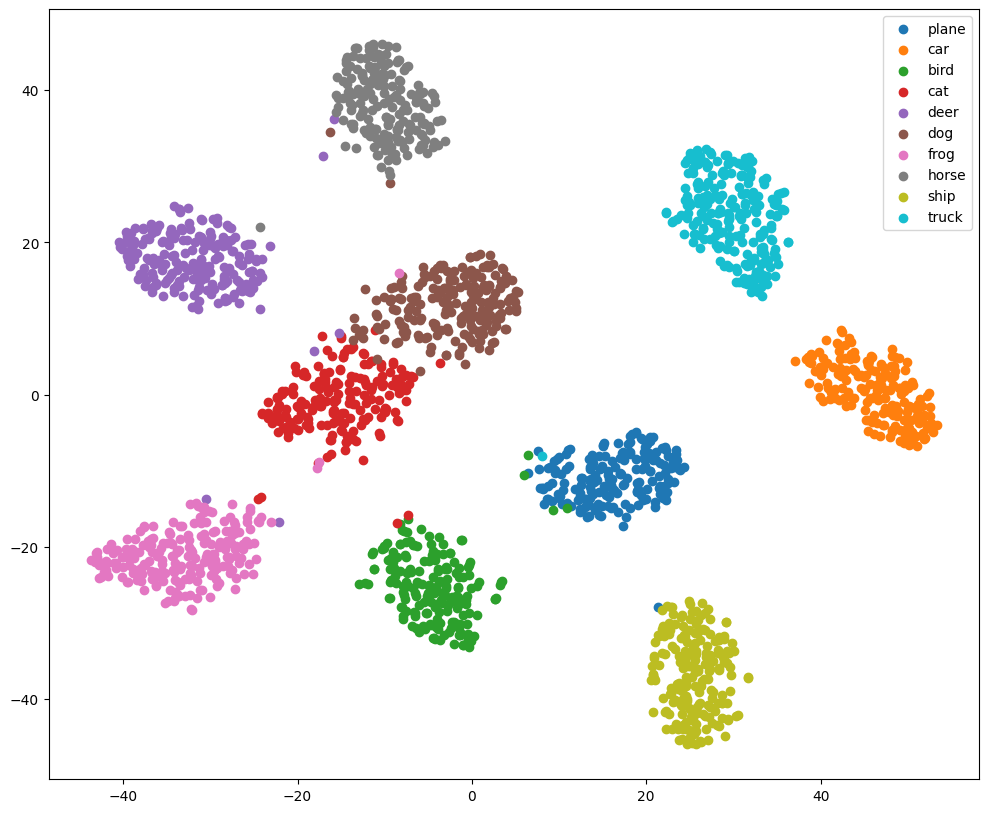

In [48]:
# TODO: Plot Results
fig = plt.figure(figsize=(12, 10))
unique_labels = np.unique(sample_labels)
for label in unique_labels:
    indices = sample_labels == label
    plt.scatter(tsne_output[indices, 0], tsne_output[indices, 1],
                 label=classes[label], cmap='viridis')
plt.legend()
plt.show()

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [49]:
# TODO: Select an Image
random_idx = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[random_idx]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [50]:
# TODO: Get Intermediate Output
clipped = nn.Sequential(
    *list(net_classification.children())[:2]
)
print(clipped)
intermediate_output = clipped(image.unsqueeze(0).to(device))

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (res_con): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

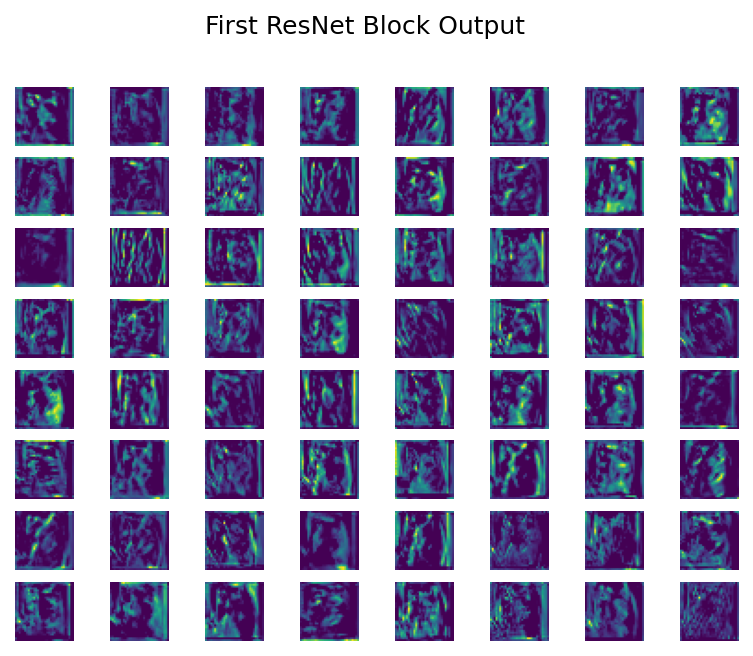

In [51]:
def plot_intermediate_output(result, title=None):
    """ Plots the intermediate output of shape
      N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

# TODO: Plot Intermediate Output
plot_intermediate_output(intermediate_output, title="First ResNet Block Output")

## CIFAR100

In this section, we aim to test the trained model on a different dataset. For this purpose, we will use the CIFAR100 dataset, which is similar to CIFAR10 but has different types and numbers of classes. In order for the model to perform well on the new dataset, we need to modify the last layer of the model. As you know from the previous section, the last layer of the model is a linear layer that maps the features to the number of classes. In this section, due to the increase in the number of classes, we plan to modify this layer and train the new linear layer with the new dataset. Note that all other layers and weights of the model will remain fixed and unchanged; only the last layer will be retrained.

### Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms.

In [52]:
# TODO: Data Transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
# TODO: Load Train and Test Data
train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test
)

# TODO: Define Data Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


In [53]:
classes = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee",
    "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee",
    "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster",
    "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse",
    "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum",
    "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train",
    "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]
print(len(classes))

100


### Visualization

Visualize 1 random images from each class.

- **Hint**:  You can use `plt.subplots` for visualization

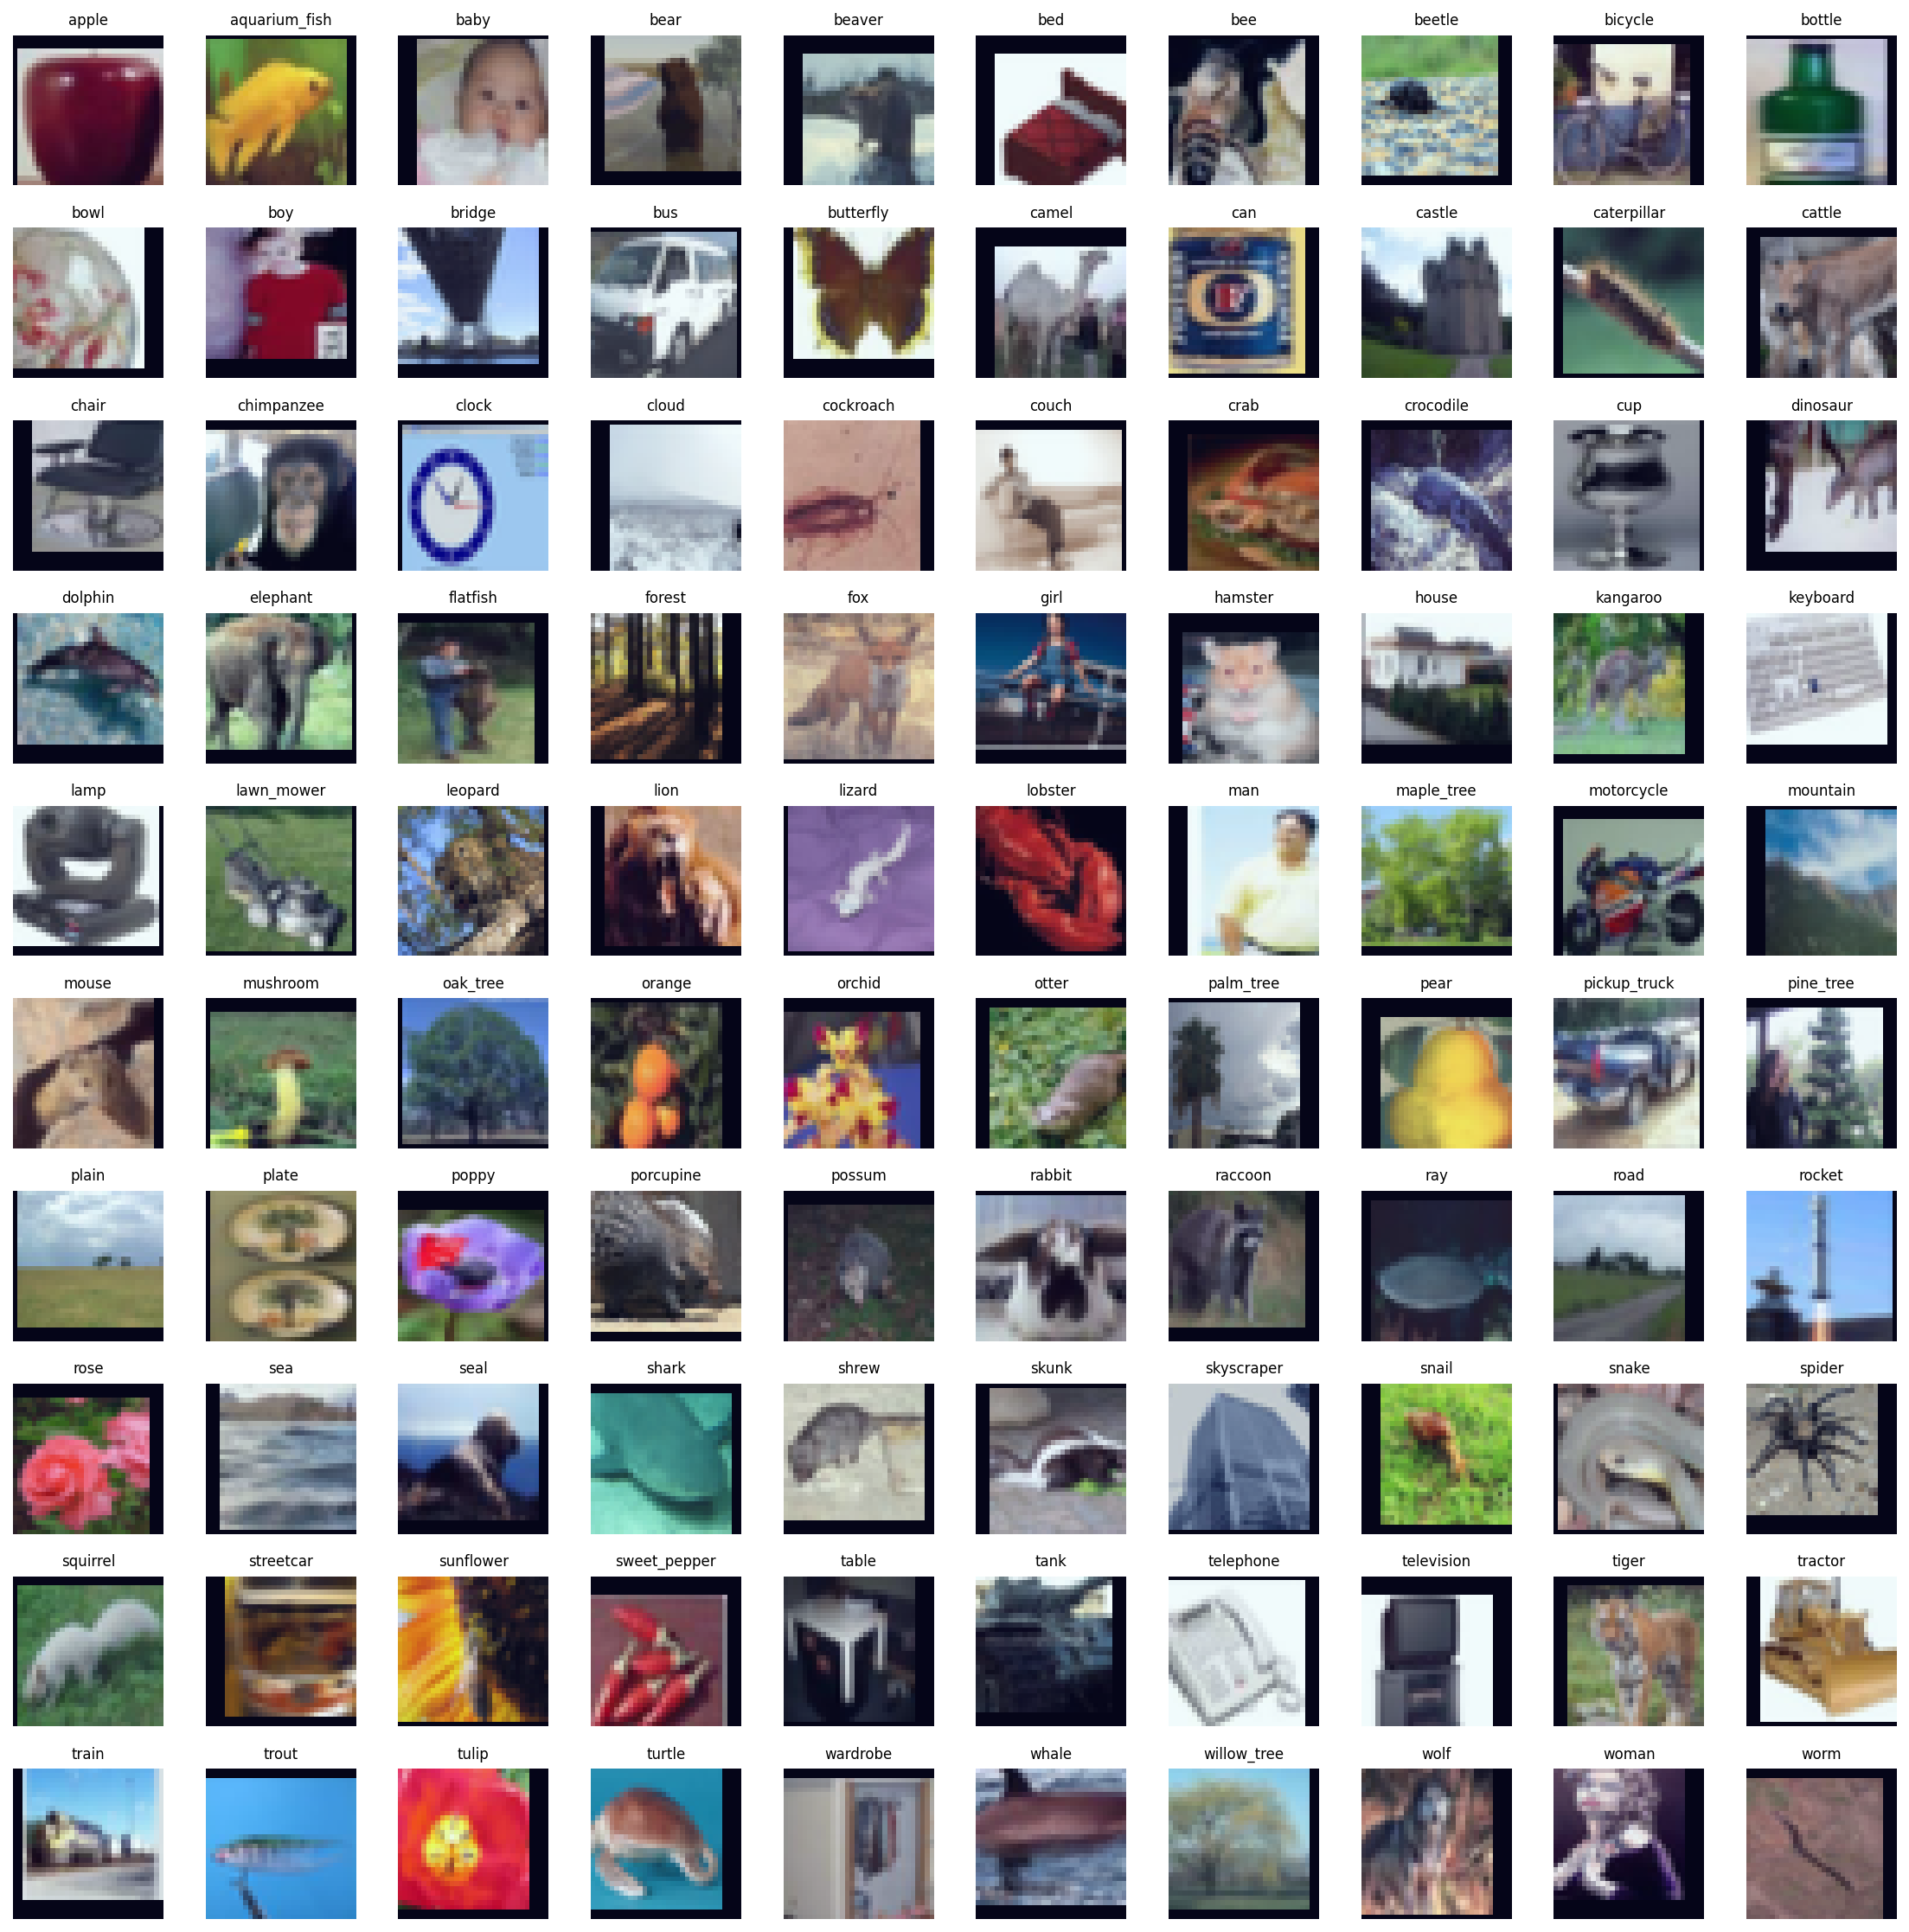

In [54]:
# TODO: Find One Image from Each Class
images_per_class = {}

for idx, class_name in enumerate(classes):
    class_indices = [i for i, label in enumerate(train_dataset.targets) if label == idx]

    random_idx = random.choice(class_indices)

    images_per_class[class_name] = train_dataset[random_idx][0]

# TODO: Plot Images
fig, axes = plt.subplots(10, 10, figsize=(15, 15))  # Create a 10x10 grid for visualization
axes = axes.ravel()

for i, (class_name, image) in enumerate(images_per_class.items()):
    ax = axes[i]
    image = image.permute(1, 2, 0).numpy()
    image = image * 0.247 + 0.491
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title(class_name, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Modify Model

Change the final linear layer of the model according to the new number of classes And freeze all other layers.
- Do not forgot to move model to `device`

In [55]:
# Load Pretrained Model
model = Resnet18(ResidualBlock)
model.load_state_dict(torch.load("resnet18.pth"))

# Freeze All Layers
for param in model.parameters():
    param.requires_grad = False

# Modify The Last Linear Layer
model.fc = nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes

# Move Model to Device
model = model.to(device)


### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [56]:
# TODO: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

### Train

Train the Model (Only Last Layer)

In [57]:
# TODO: Train The Model
def train(model, train_loader, criterion, optimizer, device, num_epochs=20):
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm.tqdm(train_loader, leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        avg_loss = running_loss / len(train_loader.dataset)

        print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

train(model, train_loader, criterion, optimizer, device, num_epochs=20)


Epoch [1/20], Loss: 3.4619, Train Accuracy: 18.03%


Epoch [2/20], Loss: 3.0111, Train Accuracy: 25.13%


Epoch [3/20], Loss: 2.8600, Train Accuracy: 28.36%


Epoch [4/20], Loss: 2.7557, Train Accuracy: 30.63%


Epoch [5/20], Loss: 2.6805, Train Accuracy: 32.38%


Epoch [6/20], Loss: 2.6187, Train Accuracy: 33.47%


Epoch [7/20], Loss: 2.5653, Train Accuracy: 34.76%


Epoch [8/20], Loss: 2.5251, Train Accuracy: 35.49%


Epoch [9/20], Loss: 2.4883, Train Accuracy: 36.55%


Epoch [10/20], Loss: 2.4563, Train Accuracy: 37.09%


Epoch [11/20], Loss: 2.4288, Train Accuracy: 37.66%


Epoch [12/20], Loss: 2.3993, Train Accuracy: 38.39%


Epoch [13/20], Loss: 2.3741, Train Accuracy: 38.85%


Epoch [14/20], Loss: 2.3558, Train Accuracy: 39.05%


Epoch [15/20], Loss: 2.3335, Train Accuracy: 39.79%


Epoch [16/20], Loss: 2.3201, Train Accuracy: 40.14%


Epoch [17/20], Loss: 2.3042, Train Accuracy: 40.36%


Epoch [18/20], Loss: 2.2858, Train Accuracy: 40.85%


Epoch [19/20], Loss: 2.2715, Train Accuracy: 41.29%


Epoch [20/20], Loss: 2.2621, Train Accuracy: 41.38%


### Test

Evaluate the Model on CIFAR-100 Test Set. 40% accuracy is sufficient.


In [58]:
# TODO: Evaluate Model on CIFAR100
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)


            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

test_accuracy = evaluate(model, test_loader, device)
# TODO: Print Accuracy
print(f'Test Accuracy on CIFAR-100: {test_accuracy:.2f}%')


Test Accuracy on CIFAR-100: 41.01%


### Question
You might think that 40% accuracy is quite low. However, first of all, consider that the classification is done over 100 classes. The accuracy of a random model in this case is 1%. Also, we only changed one linear layer of the model, and the rest of the weights remained unchanged. What do you think is the reason the model can achieve a reasonably good generalization ability on a completely new dataset with just the change of one linear layer at the end?

Answer:\
Since the model was pretrained on CIFAR-10, it already learned useful features from a dataset similar to CIFAR-100, such as basic shapes, textures, and object parts. These features are still relevant for CIFAR-100, even though the classes differ. By only retraining the final linear layer, the model can adapt its decision-making to the new classes while retaining the valuable learned representations from CIFAR-10. This allows the model to generalize well to CIFAR-100 with minimal modifications, leveraging transfer learning to make efficient use of the pretrained features.

### Visualize incorrectly predicted samples from testset

Visualize *10* random images from testset that are incorrectly predicted by the model

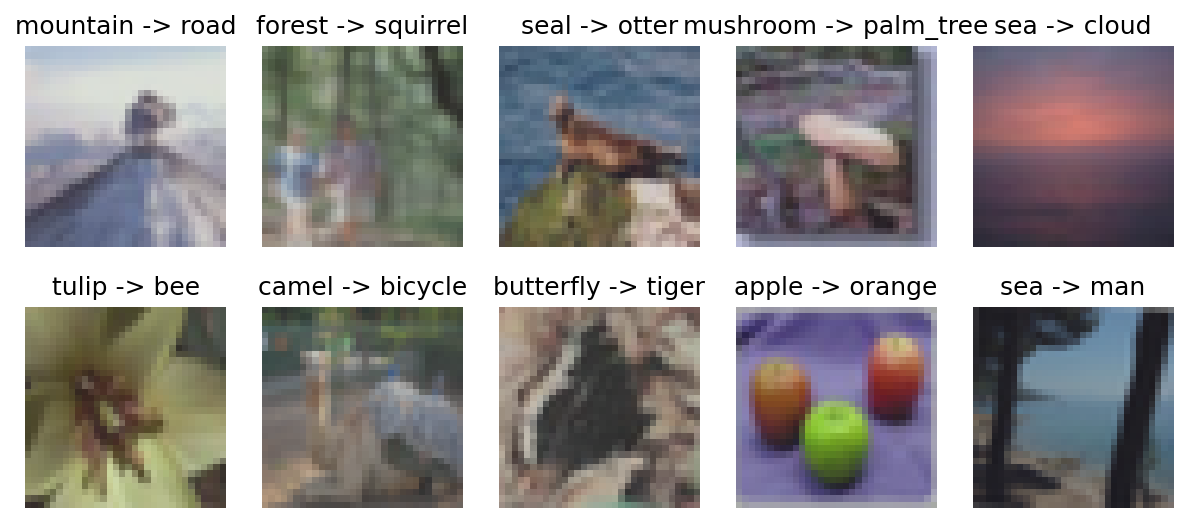

In [59]:
# TODO: Plot Samples with Wrong Predicted Classes
import warnings
warnings.filterwarnings('ignore')


dataiter = iter(test_loader)
images, labels = next(dataiter)

selected_images = []
selected_images_label = []

for images, labels in test_loader:
    for img, label in zip(images, labels):
        class_name = classes[label]
        if label != torch.argmax(model(img.to(device).unsqueeze(0)), dim=1):
            selected_images.append(img)
            selected_images_label.append(class_name)
        if len(selected_images) == 10:
            break
    if len(selected_images) == 10:
        break

# Plot Images
fig, axes = plt.subplots(2, 5, figsize=(5 * 2, 2 * 2))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])

for row in range(2):
    for col in range(5):
        ax = axes[row, col]
        img = selected_images[row*5 + col]
        img = img * std[:, None, None] + mean[:, None, None]
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{selected_images_label[row*5 + col]} -> {classes[torch.argmax(model(selected_images[row*5 + col].to(device).unsqueeze(0)), dim=1)]}')
plt.show()

### Plot accuracy for each class

Plot accuracy of model on testset for each class.

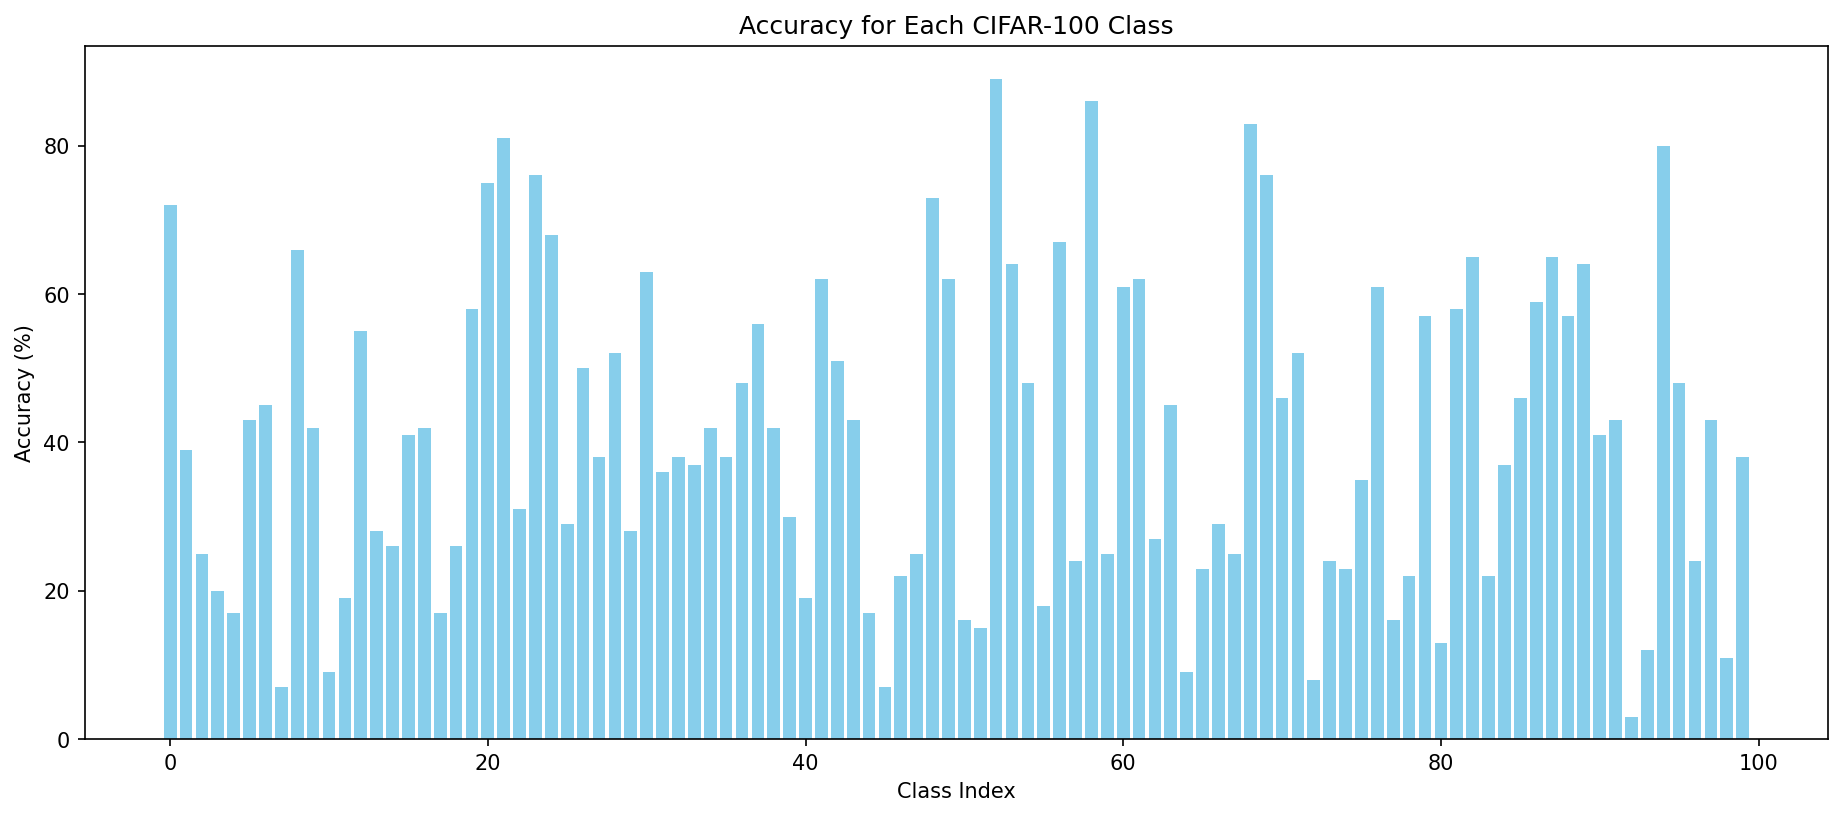

In [60]:
# TODO: Calculate Accuracy for Each Class
def calculate_classwise_accuracy(model, test_loader, device):
    class_correct = [0] * 100
    class_total = [0] * 100

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update the count of correct predictions and total images per class
            for i in range(len(labels)):
                label = labels[i]
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1

    # Calculate accuracy for each class
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(100)]

    return class_accuracy

# TODO: Calculate Accuracy for Each Class
classwise_accuracy = calculate_classwise_accuracy(model, test_loader, device)

# TODO: Plot Class-Wise Accuracy
plt.figure(figsize=(15, 6))
plt.bar(range(100), classwise_accuracy, color='skyblue')
plt.xlabel('Class Index')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Each CIFAR-100 Class')
plt.show()


### The classes with the best and worst accuracy

Based on the results from the previous section, obtain the 5 classes with the best accuracy and the 5 classes with the worst accuracy on the testset, and display one sample from each of them.

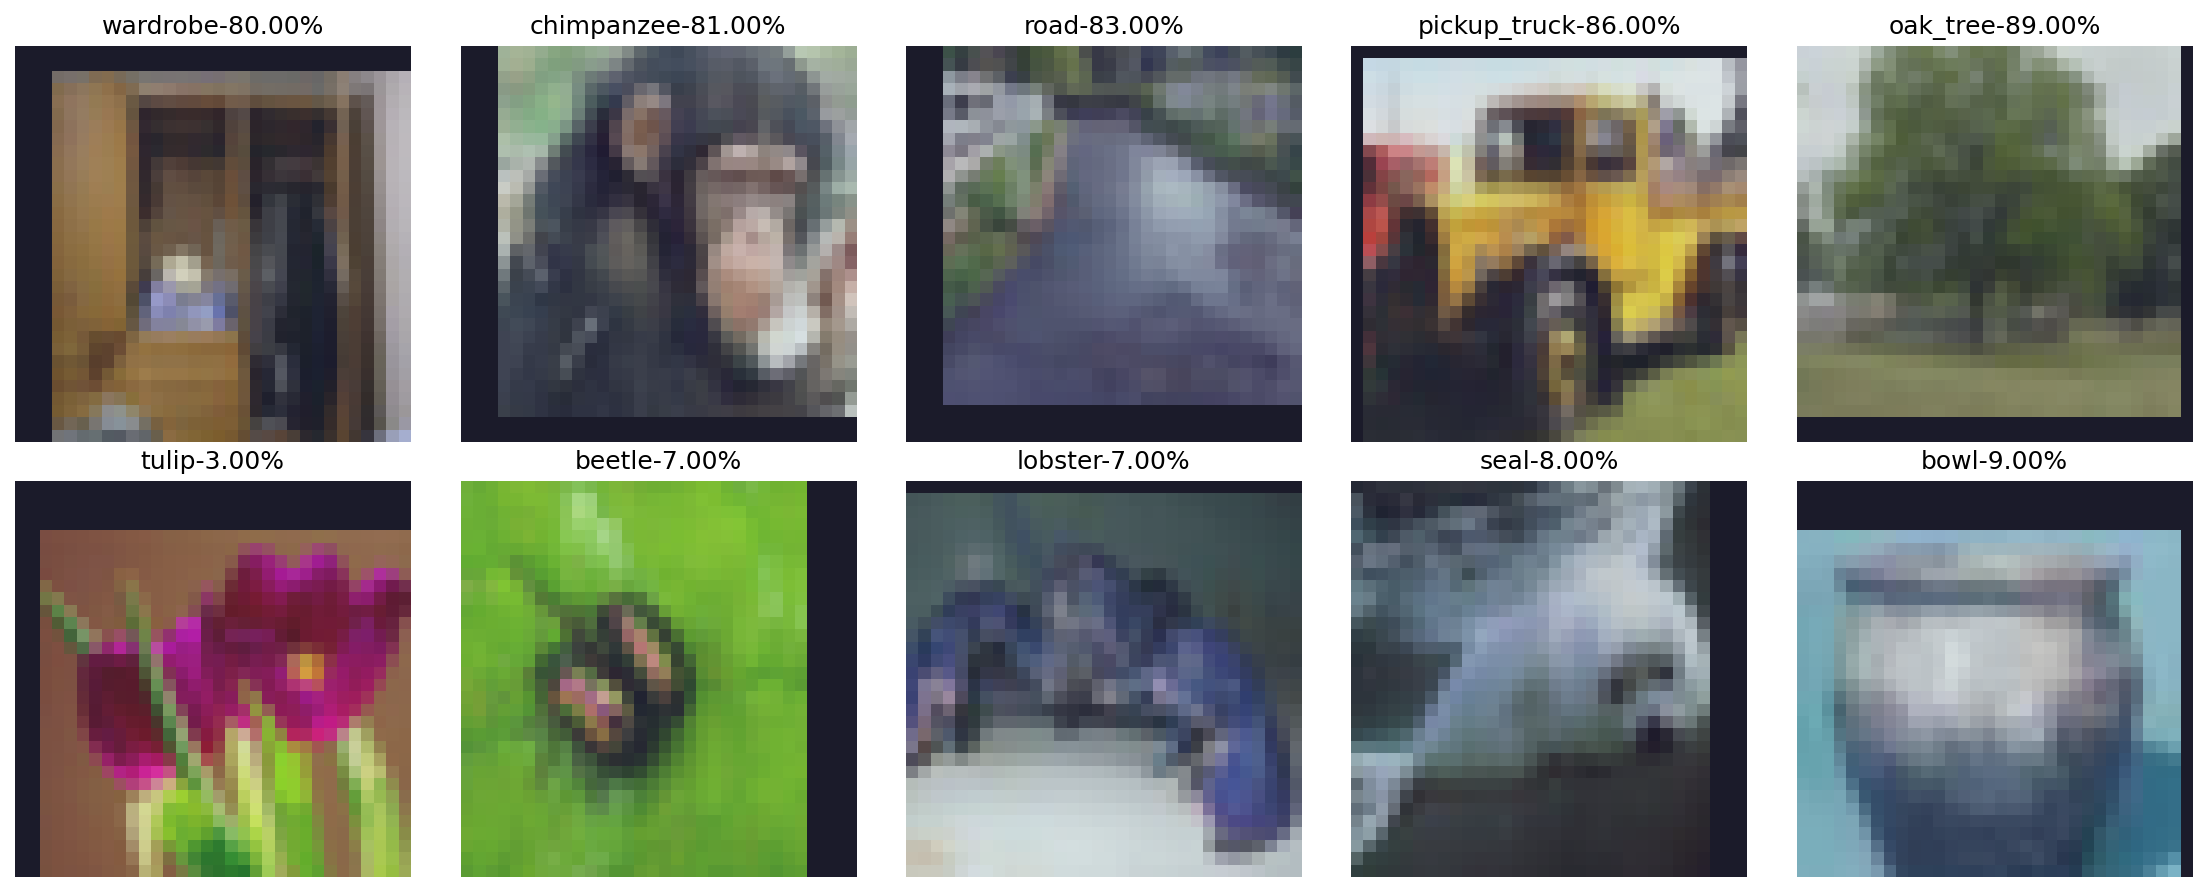

In [61]:
# TODO: Find Top 5 Best and Worst Performing Classes
def find_best_worst_classes(classwise_accuracy, train_dataset):
    sorted_indices = np.argsort(classwise_accuracy)
    best_classes = sorted_indices[-5:]
    worst_classes = sorted_indices[:5]

    best_class_images = []
    worst_class_images = []

    for class_idx in best_classes:
        class_indices = [i for i, label in enumerate(train_dataset.targets) if label == class_idx]
        random_idx = random.choice(class_indices)
        best_class_images.append(train_dataset[random_idx][0])

    for class_idx in worst_classes:
        class_indices = [i for i, label in enumerate(train_dataset.targets) if label == class_idx]
        random_idx = random.choice(class_indices)
        worst_class_images.append(train_dataset[random_idx][0])

    return best_class_images, worst_class_images, best_classes, worst_classes

best_class_images, worst_class_images, best_classes, worst_classes = find_best_worst_classes(classwise_accuracy, train_dataset)
# Plot a Sample Image From Each of The Best and Worst Performing Classes

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (img, class_idx) in enumerate(zip(best_class_images, best_classes)):
    ax = axes[0, i]
    img = img.permute(1, 2, 0).cpu().numpy()
    img = img * 0.2023 + 0.4914
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f'{classes[class_idx]}-{classwise_accuracy[class_idx]:.2f}%')
    ax.axis('off')

for i, (img, class_idx) in enumerate(zip(worst_class_images, worst_classes)):
    ax = axes[1, i]
    img = img.permute(1, 2, 0).cpu().numpy()
    img = img * 0.2023 + 0.4914
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f'{classes[class_idx]}-{classwise_accuracy[class_idx]:.2f}%')
    ax.axis('off')

plt.tight_layout()
plt.show()


### Question
What do you think is the reason for the significant accuracy difference between different classes? What differences do you observe between the classes with the best and worst accuracy? Can you provide an analysis of the results and relate them to the model’s feature space?

Answer:\
the model's performance is related to the fact that it was pretrained on CIFAR-10, which has similar classes and image types to CIFAR-100. Since the model has already learned general features from CIFAR-10 (such as basic shapes, textures, and object parts), it is likely to perform better on classes that share similar visual patterns or objects between CIFAR-10 and CIFAR-100. The higher accuracy on certain classes can be attributed to these similarities, as the model's learned features are more directly transferable to CIFAR-100 classes that resemble those in CIFAR-10. However, for classes that are more distinct or complex in CIFAR-100, the model may struggle because the features learned from CIFAR-10 are less relevant.